In [ ]:
"""
A deep learning model for detecting and counting different types of candy in images.

    This model is designed to identify various types of candy in input images, outputting 
    both the location (bounding boxes) and type of each detected candy. The model is fine-tuned 
    on a custom dataset using transfer learning with an object detection model.
"""

# Importing Libraries.
import json
import os


In [ ]:
# Set the paths for the dataset and model save location.
data_path = 'candy_dataset'
model_save_path = 'candy_counter_model'


In [ ]:
# Load the dataset using the specified directory path.
from datasets import load_dataset
data_dir = r"data"


In [ ]:
# Load the COCO-style JSON annotation file.
with open('data/result.json') as f:
  cocodata = json.load(f)

# Initialize a list to hold the processed data in the Hugging Face format.
huggingdata = []

# Iterate through the images.
for image in cocodata['images']:
  # Set file name and assign a unique image identifier.
  image['file_name'] = image['file_name']
  image['image_id'] = image['id']
  # Initialize the 'objects' dictionary for each image.
  image['objects'] = {'bbox': [], 'category': [], 'area': [], 'id': []}

  # Iterate through annotations to find bounding boxes and labels for each image.
  for annot in cocodata['annotations']:
    # Check if the annotation corresponds to the current image.
    if annot['image_id'] == image['id']:
      # Add the annotation.
      image['objects']['bbox'].append(annot['bbox'])
      image['objects']['category'].append(annot['category_id'])
      image['objects']['area'].append(annot['area'])
      image['objects']['id'].append(annot['id'])
  # Append the image dict with annotations to the list.
  huggingdata.append(image)


In [ ]:
# Write the processed data to a JSON lines file
with open("data/metadata.jsonl", 'w') as f:
  for item in huggingdata:
    f.write(json.dumps(item) + "\n")
    

In [ ]:
# Load the dataset from a local directory of images using the "imagefolder" format.
from datasets import load_dataset
dataset = load_dataset("imagefolder", data_dir=data_dir, split='train')
print(dataset)

# Split the dataset into training and testing sets with an 80-20 ratio.
split_dataset = dataset.train_test_split(test_size=0.2)


Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['image', 'width', 'height', 'id', 'image_id', 'objects'],
    num_rows: 11
})


In [ ]:
# Define mappings between class IDs and labels for the object detection model.
id2label = {0: "Moon", 1: "Insect", 2: "Black_Star", 3: "Grey_Star", 4:"Unicorn_Whole", 5:"Unicorn_Head", 6: "Owl", 7: "Cat"}
label2id = {label: idx for idx, label in id2label.items()}


In [ ]:
# Specify the model and image size for the object detection task.
MODEL_NAME = "microsoft/conditional-detr-resnet-50"
IMAGE_SIZE = 480


In [ ]:
# Initialize an image processor with specified settings for preprocessing images.
from transformers import AutoImageProcessor

MAX_SIZE = IMAGE_SIZE

image_processor = AutoImageProcessor.from_pretrained(
    MODEL_NAME,
    do_resize=True,
    size={"max_height": MAX_SIZE, "max_width": MAX_SIZE},
    do_pad=True,
    pad_size={"height": MAX_SIZE, "width": MAX_SIZE},
)


In [ ]:
# Define data augmentation and transformation pipelines.
import albumentations as A

# train_augment_and_transform: Augmentation pipeline for training images.
train_augment_and_transform = A.Compose(
    [
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
    ],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"], clip=True, min_area=25),
)

# validation_transform: Transformation pipeline for validation images.
validation_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"], clip=True),
)


In [ ]:
# Format image annotations in COCO format.
def format_image_annotations_as_coco(image_id, categories, areas, bboxes):
    annotations = []
    for category, area, bbox in zip(categories, areas, bboxes):
        formatted_annotation = {
            "image_id": image_id,
            "category_id": category,
            "iscrowd": 0,
            "area": area,
            "bbox": list(bbox),
        }
        annotations.append(formatted_annotation)

    return {
        "image_id": image_id,
        "annotations": annotations,
    }


In [ ]:
# Format image annotations in COCO format.
def augment_and_transform_batch(examples, transform, image_processor, return_pixel_mask=False):

    images = []
    annotations = []
    for image_id, image, objects in zip(examples["image_id"], examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))

        # apply augmentations.
        output = transform(image=image, bboxes=objects["bbox"], category=objects["category"])
        images.append(output["image"])

        # format annotations in COCO format.
        formatted_annotations = format_image_annotations_as_coco(
            image_id, output["category"], objects["area"], output["bboxes"]
        )
        annotations.append(formatted_annotations)

    # Apply the image processor transformations: resizing, rescaling, normalization.
    result = image_processor(images=images, annotations=annotations, return_tensors="pt")

    if not return_pixel_mask:
        result.pop("pixel_mask", None)

    return result


In [ ]:
from functools import partial

# Make transform functions for batch and apply for dataset splits.
train_transform_batch = partial(
    augment_and_transform_batch, transform=train_augment_and_transform, image_processor=image_processor
)
# validation_transform_batch: Applies the validation transformations.
validation_transform_batch = partial(
    augment_and_transform_batch, transform=validation_transform, image_processor=image_processor
)
# Apply the transform functions to the dataset splits.
train_dataset = split_dataset['train'].with_transform(train_transform_batch)
test_dataset = split_dataset['test'].with_transform(validation_transform_batch)


In [ ]:
import torch

# Define a custom collate function for batching data during training and evaluation.
def collate_fn(batch):
    data = {}

    # Stack pixel values for the batch, creating a single tensor with all images.
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])

    # Collect labels as a list.
    data["labels"] = [x["labels"] for x in batch]

    # If pixel masks are present in the batch, stack them into a tensor.
    if "pixel_mask" in batch[0]:
        data["pixel_mask"] = torch.stack([x["pixel_mask"] for x in batch])

    return data


In [ ]:
from transformers.image_transforms import center_to_corners_format

# Convert bounding boxes from YOLO format to Pascal VOC format.
def convert_bbox_yolo_to_pascal(boxes, image_size):
    # convert center to corners format
    boxes = center_to_corners_format(boxes)

    # convert to absolute coordinates
    height, width = image_size
    boxes = boxes * torch.tensor([[width, height, width, height]])

    return boxes


In [ ]:
import numpy as np
from dataclasses import dataclass
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Define a data structure to store model output.
@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor

# Compute evaluation metrics for object detection, specifically mAP.
@torch.no_grad()
def compute_metrics(evaluation_results, image_processor, threshold=0.0, id2label=None):

     # Extract predictions and ground truth targets from the evaluation results.
    predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

    # Initialize lists to store image sizes, processed targets, and processed predictions.
    image_sizes = []
    post_processed_targets = []
    post_processed_predictions = []

    # Process each batch in targets.
    for batch in targets:
        batch_image_sizes = torch.tensor(np.array([x["orig_size"] for x in batch]))
        image_sizes.append(batch_image_sizes)
        for image_target in batch:
            boxes = torch.tensor(image_target["boxes"])
            boxes = convert_bbox_yolo_to_pascal(boxes, image_target["orig_size"])
            labels = torch.tensor(image_target["class_labels"])
            post_processed_targets.append({"boxes": boxes, "labels": labels})

    # Process each batch in predictions.
    for batch, target_sizes in zip(predictions, image_sizes):
        batch_logits, batch_boxes = batch[1], batch[2]
        output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
        # Post-process predictions to match the target format and threshold.
        post_processed_output = image_processor.post_process_object_detection(
            output, threshold=threshold, target_sizes=target_sizes
        )
        post_processed_predictions.extend(post_processed_output)

    # Compute metrics.
    metric = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
    metric.update(post_processed_predictions, post_processed_targets)
    metrics = metric.compute()

    # Replace list of per class metrics with separate metric for each class.
    classes = metrics.pop("classes")
    map_per_class = metrics.pop("map_per_class")
    mar_100_per_class = metrics.pop("mar_100_per_class")
    for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
        class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
        metrics[f"map_{class_name}"] = class_map
        metrics[f"mar_100_{class_name}"] = class_mar

    # Round all metric values to 4 decimal places for cleaner output.
    metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

    return metrics

# Create a partial function for evaluation, presetting specific arguments.
eval_compute_metrics_fn = partial(
    compute_metrics, image_processor=image_processor, id2label=id2label, threshold=0.0
)


In [ ]:
from transformers import AutoModelForObjectDetection

# Load a pretrained object detection model with customized label mappings.
model = AutoModelForObjectDetection.from_pretrained(
    MODEL_NAME,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)


Some weights of ConditionalDetrForObjectDetection were not initialized from the model checkpoint at microsoft/conditional-detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([8]) in the model instantiated
- class_labels_classifier.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([8, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer, TrainingArguments

# Define training arguments for model training and evaluation.
training_args = TrainingArguments(
    output_dir="./results",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=4,
    num_train_epochs=800,
    logging_steps=10,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to="none",
    load_best_model_at_end=True,
    fp16=False,
    dataloader_num_workers=0,
    learning_rate=5e-5,
    lr_scheduler_type="cosine",
    weight_decay=1e-4,
    max_grad_norm=0.01,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    eval_strategy="epoch",
    eval_do_concat_batches=False,
)


In [ ]:
# Initialize a Trainer instance to manage model training and evaluation.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    processing_class=image_processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)

# Start training.
trainer.train()

TrainOutput(global_step=800, training_loss=0.8008520665764809, metrics={'train_runtime': 1120.4354, 'train_samples_per_second': 5.712, 'train_steps_per_second': 0.714, 'total_flos': 1.1498100719616e+18, 'train_loss': 0.8008520665764809, 'epoch': 800.0})

In [ ]:
# Save the trained model to the specified directory.
trainer.save_model('candy_detector')


In [ ]:
from pprint import pprint

# Evaluate the model on the test dataset and display evaluation metrics.
metrics = trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")
pprint(metrics)

{'epoch': 800.0,
 'test_loss': 0.602013349533081,
 'test_map': 0.5214,
 'test_map_50': 0.6816,
 'test_map_75': 0.6816,
 'test_map_Black_Star': -1.0,
 'test_map_Cat': -1.0,
 'test_map_Grey_Star': 0.51,
 'test_map_Insect': -1.0,
 'test_map_Moon': -1.0,
 'test_map_Owl': -1.0,
 'test_map_Unicorn_Head': -1.0,
 'test_map_Unicorn_Whole': 0.5328,
 'test_map_large': -1.0,
 'test_map_medium': 0.801,
 'test_map_small': 0.4177,
 'test_mar_1': 0.2475,
 'test_mar_10': 0.8025,
 'test_mar_100': 0.8025,
 'test_mar_100_Black_Star': -1.0,
 'test_mar_100_Cat': -1.0,
 'test_mar_100_Grey_Star': 0.825,
 'test_mar_100_Insect': -1.0,
 'test_mar_100_Moon': -1.0,
 'test_mar_100_Owl': -1.0,
 'test_mar_100_Unicorn_Head': -1.0,
 'test_mar_100_Unicorn_Whole': 0.78,
 'test_mar_large': -1.0,
 'test_mar_medium': 0.8,
 'test_mar_small': 0.815,
 'test_runtime': 0.589,
 'test_samples_per_second': 5.093,
 'test_steps_per_second': 1.698}


In [ ]:
# Importing more libraries.
import torch
import requests

# Load a test image from the dataset for inference.
from PIL import Image, ImageDraw
from transformers import AutoImageProcessor, AutoModelForObjectDetection

image = split_dataset['test'][0].get("image")


In [ ]:
# Set the device to "cuda" for GPU acceleration if available.
device = "cuda"

# Load the pretrained image processor and object detection model.
image_processor = AutoImageProcessor.from_pretrained('candy_detector')
model = AutoModelForObjectDetection.from_pretrained('candy_detector')
model = model


In [ ]:
with torch.no_grad():
    # Process the image and perform object detection.
    inputs = image_processor(images=[image], return_tensors="pt")
    outputs = model(**inputs)
    target_sizes = torch.tensor([[image.size[1], image.size[0]]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.24, target_sizes=target_sizes)[0]

# Display detected objects with their confidence scores and bounding boxes.
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )


Detected Grey_Star with confidence 0.551 at location [73.82, 164.87, 113.97, 194.3]
Detected Black_Star with confidence 0.465 at location [135.07, 66.63, 159.66, 86.9]
Detected Grey_Star with confidence 0.458 at location [245.01, 159.44, 287.08, 188.13]
Detected Cat with confidence 0.448 at location [6.94, 54.22, 40.38, 105.35]
Detected Black_Star with confidence 0.438 at location [204.83, 135.4, 231.01, 155.69]
Detected Black_Star with confidence 0.436 at location [100.17, 98.93, 125.71, 117.75]
Detected Grey_Star with confidence 0.43 at location [167.1, 83.8, 198.32, 116.63]
Detected Black_Star with confidence 0.426 at location [205.71, 36.38, 233.27, 59.07]
Detected Black_Star with confidence 0.422 at location [34.89, 157.85, 62.84, 179.13]
Detected Black_Star with confidence 0.401 at location [59.89, 126.15, 87.96, 146.45]
Detected Grey_Star with confidence 0.401 at location [244.45, 158.43, 286.04, 185.69]
Detected Black_Star with confidence 0.396 at location [34.68, 158.28, 62.37

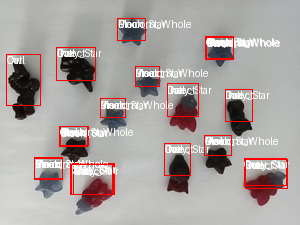

In [ ]:
# Draw bounding boxes and labels on the image to visualize detected objects.
draw = ImageDraw.Draw(image)

# Loop through each detected object in the results.
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    # Format bounding box coordinates.
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    # Draw the bounding box on the image.
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    # Draw the label text above the bounding box.
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

# Display the annotated image with bounding boxes and labels.
image


In [ ]:
def candy_counter(image):
    # Initialize a dictionary to count occurrences of each candy type.
    counts = {
        'Moon': 0,
        'Insect': 0,
        'Black_star': 0,
        'Grey_star': 0,
        'Unicorn_whole': 0,
        'Unicorn_head': 0,
        'Owl': 0,
        'Cat': 0
    }
    # Load the pretrained image processor and model for object detection.
    image_processor = AutoImageProcessor.from_pretrained("candy_detector_final")
    model = AutoModelForObjectDetection.from_pretrained("candy_detector_final")
    model = model.to(device)
    
    # Run inference to detect objects in the image.
    with torch.no_grad():
        inputs = image_processor(images=[image], return_tensors="pt")
        outputs = model(**inputs.to(device))
        # Get the target size to scale bounding boxes to the original image dimensions.
        target_sizes = torch.tensor([[image.size[1], image.size[0]]])
        # Post-process outputs to filter detections based on confidence threshold (0.3).
        results = image_processor.post_process_object_detection(outputs, threshold=0.3, target_sizes=target_sizes)[0]

    # Count each detected candy type by label.
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
        )
        # Increment the count for the detected label.
        counts[model.config.id2label[label.item()]] += 1
    
    # Return the dictionary with counts for each candy type.
    return counts